In [1]:
import time
import pickle
from tabulate import tabulate
from IPython.display import display

import pandas as pd
pd.set_option('display.colheader_justify', 'center')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV

from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier,RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score, f1_score, roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

### Helper functions

In [256]:
randomState = 42
url='Datasets/diabetes_dataset.csv'

def getData(url = url):

    url = url
    df = pd.read_csv(url)
    return df

def cleanData(url = url):

    #Drop duplicates
    print('Dropping duplicates...\n')
    df.drop_duplicates(inplace=True)
    time.sleep(1)

    #Change all column names to lower case
    print('Converting to lower case columns and data...')
    df.columns = df.columns.str.replace('Diabetes_binary','diabetes').str.lower()

    #This next for loop doesn't get executed because there are no "object" type columns
    for col in df.select_dtypes(object).columns:
        df[col] = df[col].str.lower().str.replace(' ', '_')

    time.sleep(1)

    return df

def splitData(df):

    target = df.diabetes
    data = df.drop(columns=['diabetes'])
    dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=randomState)
    dfTrain, dfVal, yTrain, yVal = train_test_split(dfTrainFull, yTrainFull, test_size=0.25, random_state=randomState)

    print(  f'Dataset has been split in: Training set with {len(yTrain)} samples, '
            f'Validation set with {len(yVal)} samples and Test set with {len(yTest)} samples')

    return dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest

def printHelper(f1Score, auc):
    
    print('\n---------------------------------')
    print(f'Test set weighted f1-score: {f1Score}')
    print(f'Test set auc: {auc}')
    print('---------------------------------\n')

def printResults(results):  
    print('\n-----------------------------------------')
    for i,j in results.items():
        print('{:<20}:  {:<6}'.format(i, " ± ".join([str(x) for x in j])))
    print('-----------------------------------------')

    
def getMeasures(model):

    yTestpredProb = model.predict_proba(dfTest)[:,1]
    yTestpred = model.predict(dfTest)
    auc = round(roc_auc_score(yTest, yTestpredProb),3)
    f1Score = round(f1_score(yTest, yTestpred, average='weighted'),3)
    modelName = type(model.named_steps.classifier).__name__

    printHelper(f1Score, auc)

    print(classification_report(yTest, yTestpred))

    fig1, ax1 = plt.subplots(figsize=(14, 6))
    fpr, tpr, _ = roc_curve(yTest.values, yTestpredProb)
    roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, name=f'ROC_AUC {modelName}', )
    ax1.text(0.4,0.5,f'AUC = {auc}', size=14, fontweight='semibold', )
    ax1.text(0.4,0.4,f'Weighted F1  = {f1Score}', size=14, fontweight='semibold')
    ax1.legend(loc=4, prop={'size': 20})

    print()

    fig2, ax2 = plt.subplots(1,2, figsize=(16, 6))
    ax2[0].grid(False)
    ax2[1].grid(False)

    cm = confusion_matrix(yTest, yTestpred)
    cmprob = confusion_matrix(yTest, yTestpred, normalize='true')
    cm_display1 = ConfusionMatrixDisplay(cm, display_labels=['No-Diabetes', 'Diabetes'])
    cm_display2 = ConfusionMatrixDisplay(cmprob, display_labels=['No-Diabetes', 'Diabetes'])

    cm_display1.plot(ax=ax2[0])
    cm_display1.ax_.set_title("Confusion Matrix", size=16)
    cm_display2.plot(ax=ax2[1])
    cm_display2.ax_.set_title("Narmalized Confusion Matrix", size=16)
    
    rtn = {}
    rtn['test_roc_auc'] = [auc]
    rtn['test_f1-score'] = [f1Score]
    
    return rtn #[auc], [f1Score]#, yTestpred, yTestpredProb

def getResults(model, params):
    
    baseParams = ["mean_train_auc",
                  "std_train_auc",
                  "rank_test_auc",
                  "mean_train_f1_weighted",
                  "std_train_f1_weighted",
                  "rank_test_f1_weighted"
    ]
    
    allParams = baseParams + params
    
    cv_results = pd.DataFrame(model.cv_results_)

    res = cv_results[allParams]
    
    if 'param_classifier__reg_lambda' not in params:
        display(res.query('rank_test_auc < 30 & rank_test_f1_weighted < 30').sort_values(by=["rank_test_auc", "rank_test_f1_weighted"]))
    else:
        display(res.sort_values(by=["rank_test_auc", "rank_test_f1_weighted"]).head(20))

def getBestModelResults(model):
    
    cv_results = cross_validate(model,
                                dfTrainFull,
                                yTrainFull,
                                cv=outerCV,
                                scoring=['f1_weighted','roc_auc'],
                                n_jobs=-1,
                                return_train_score=True,
                                return_estimator=True,
    )

    cv_results = pd.DataFrame(cv_results)
    cv_test_scores = cv_results[['test_f1_weighted', 'train_f1_weighted', 'test_roc_auc', 'train_roc_auc']]
    cv_test_scores.columns = ['val_f1_weighted', 'val_roc_auc','train_f1_weighted', 'train_roc_auc']
    
    print("Scores after hyperparameters tuning:\n")
    
    res = cv_test_scores.copy()
    res.loc['mean'] = res.mean().round(4)
    res.loc['std'] = res.std().round(4)
    
    rtn = {}
    for col in res:
        print('{:<20}:  {:<6} +/- {:<6}'.format(col, res.loc["mean"][col], res.loc["std"][col]))
        #print(f'{col}: {res.loc["mean"][col]} +/- {res.loc["std"][col]}')
        rtn[col] = [res.loc["mean"][col], res.loc["std"][col]]
    
    return rtn

def reload(module):
    importlib.reload(module)

### Load binary unbalanced data

In [3]:
df = getData()
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


## EDA

#### Preparing and cleaning data

In [4]:
df = cleanData(df)
df

Dropping duplicates...

Converting to lower case columns and data...


,diabetes,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


#### Checking Correlations

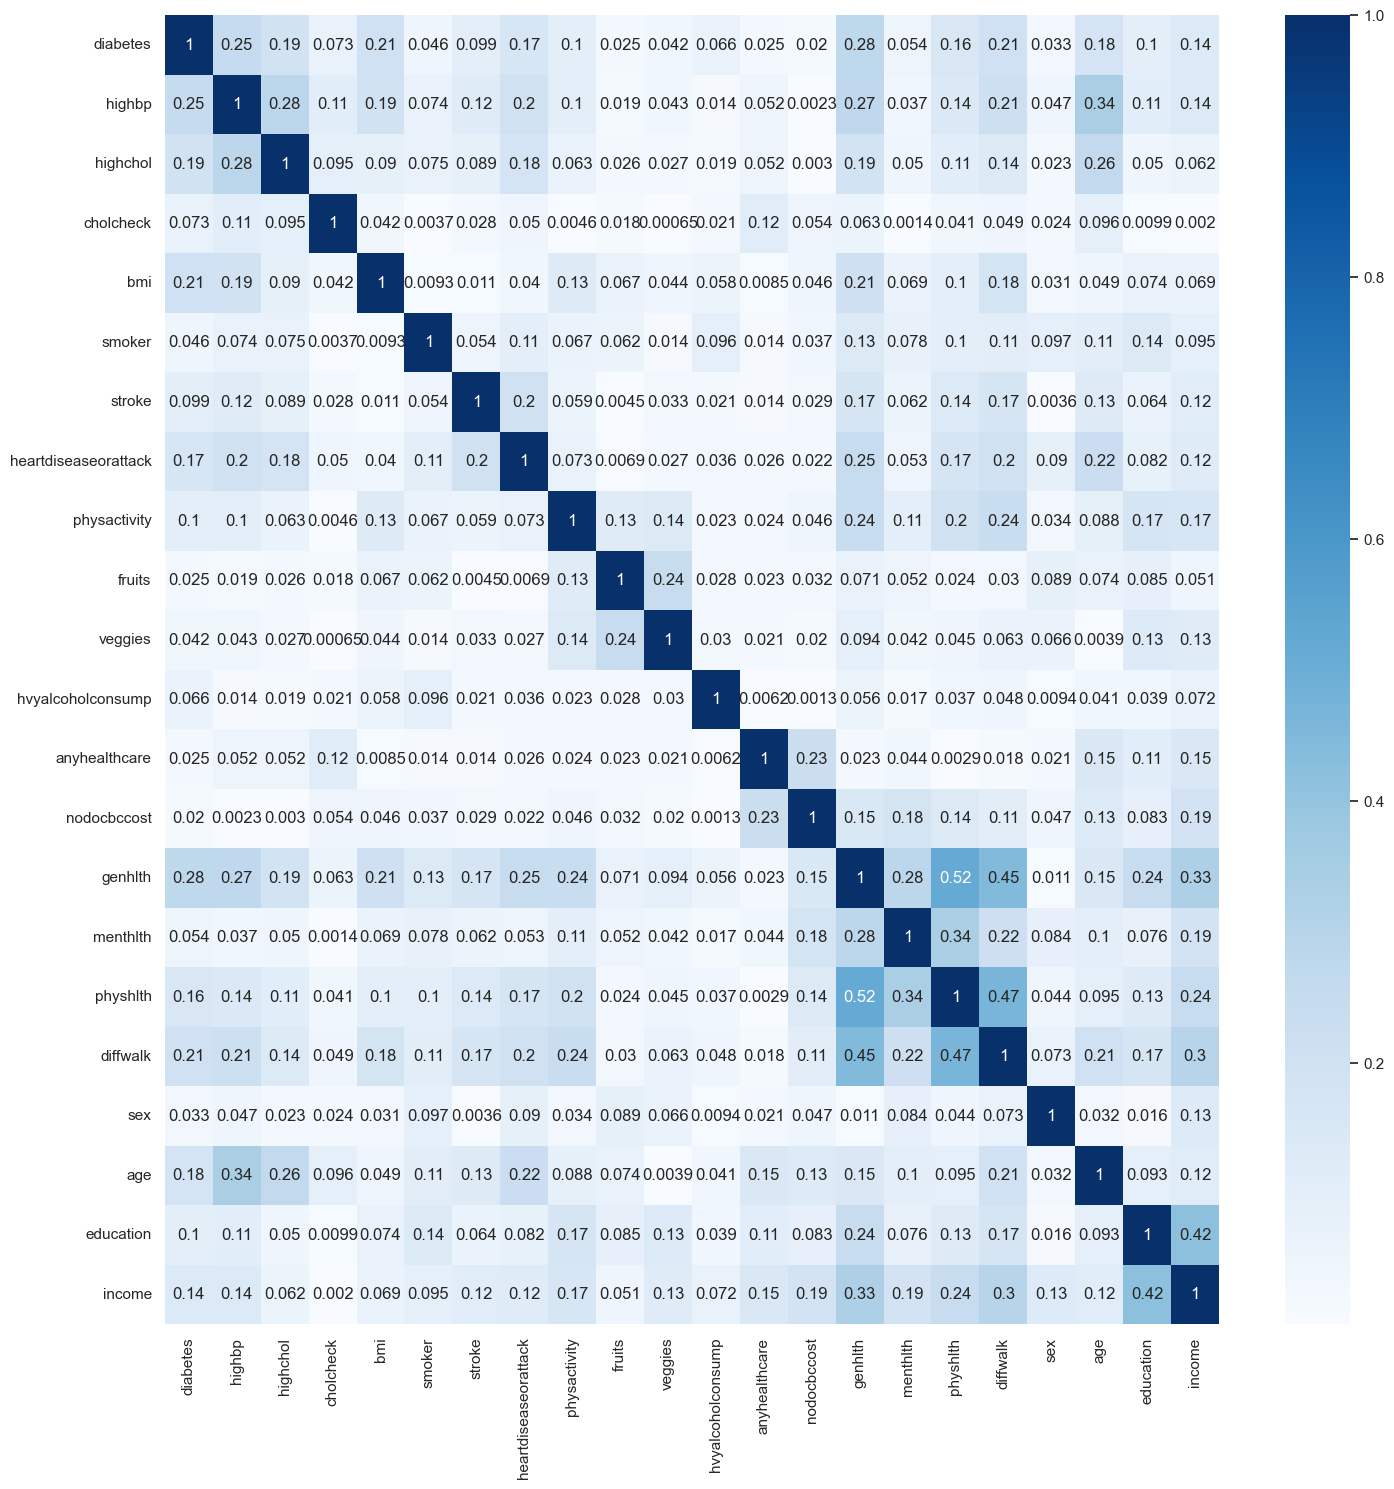

In [5]:
sns.set_theme()
corr_matrix = df.corr().abs()
plt.figure(figsize=(17,17))

_ = sns.heatmap(corr_matrix, cmap="Blues", annot=True)

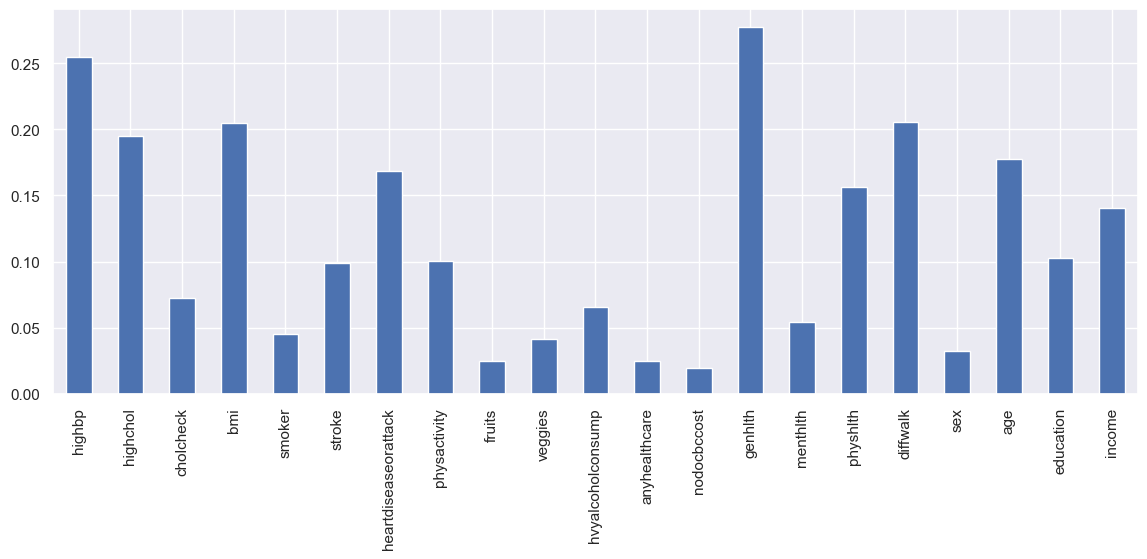

In [6]:
#corr_matrix.diabetes.sort_values(ascending=False).hist()
sns.set_theme()
dfMatrix = df.drop(columns='diabetes')
corr_matrix = dfMatrix.corrwith(df.diabetes).abs()
plt.figure(figsize=(14,5))
_ = corr_matrix.plot(kind='bar', grid=True)
_ = plt.show()    

In [7]:
corr_matrix.sort_values(ascending=False)

genhlth                 0.276940
highbp                  0.254318
diffwalk                0.205302
bmi                     0.205086
highchol                0.194944
age                     0.177263
heartdiseaseorattack    0.168213
physhlth                0.156211
income                  0.140659
education               0.102686
physactivity            0.100404
stroke                  0.099193
cholcheck               0.072523
hvyalcoholconsump       0.065950
menthlth                0.054153
smoker                  0.045504
veggies                 0.041734
sex                     0.032724
anyhealthcare           0.025331
fruits                  0.024805
nodocbccost             0.020048
dtype: float64

In [8]:
df.drop(columns=['nodocbccost', 'fruits', 'anyhealthcare', 'veggies'], inplace=True)

#### The target value is heavily imbalanced.  No Diabetes- 194377, Diabetes- 35097.

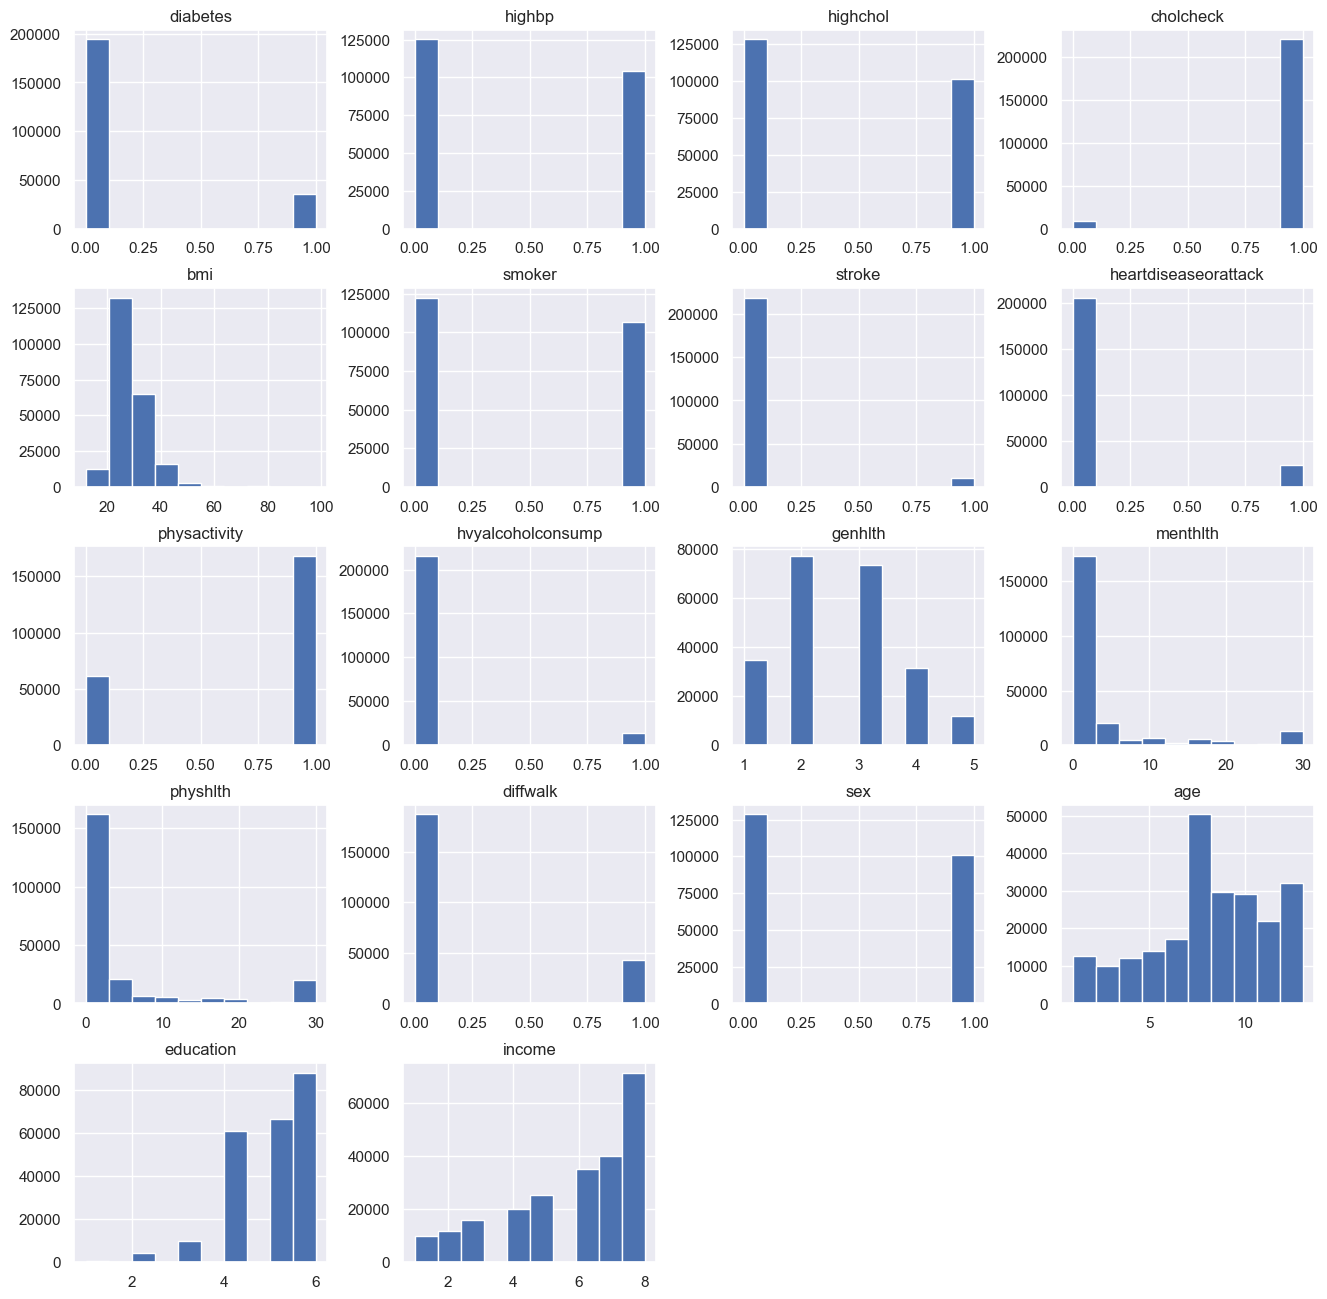

In [9]:
_= df.hist(figsize=(16,16))

In [10]:
dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest = splitData(df)

Dataset has been split in: Training set with 137684 samples, Validation set with 45895 samples and Test set with 45895 samples


#### Preprocessing

This part will be used for the Logistic Regression classifier only

In [46]:
categoricalCols = ['highbp', 'highchol', 'cholcheck','smoker','stroke',
                   'heartdiseaseorattack', 'physactivity', 'hvyalcoholconsump',
                   'genhlth','diffwalk', 'sex', 'education', 'income']

numericalCols = ['bmi', 'menthlth', 'physhlth']

In [47]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")

## ML Models

#### Setting up some variables

In [13]:
# Inner cross-validation(for Hyperparameter tuning)
innerCV = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomState)
# Outer cross-validation(for testing the tunned model)
outerCV = StratifiedKFold(n_splits=3, shuffle=True, random_state=randomState)

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

### DecisionTreeClassifier

#### Will use nested CrossValidation

inner cross-validation(for Hyperparameter tuning)

In [14]:
%%time

# Model
model_DT = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced', random_state = randomState))])

# Gridsearch params
param_grid = {
    'classifier__max_depth': (1,3,5,7,10),
    'classifier__max_leaf_nodes': (1, 5,10,15,20),
    'classifier__max_features': (1,3,5,7,10,15)
}

# Gridsearch
model_grid_search_DT = GridSearchCV(model_DT,
                                    param_grid=param_grid,
                                    scoring=scoring,
                                    n_jobs=-1,
                                    cv=innerCV,
                                    return_train_score=True,
                                    refit=False)

_ = model_grid_search_DT.fit(dfTrainFull, yTrainFull)

Wall time: 1min 15s


In [16]:
paramsDT = ["param_classifier__max_depth",
            'param_classifier__max_leaf_nodes',
            "param_classifier__max_features"]

getResults(model_grid_search_DT, paramsDT)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features
89,0.785094,0.000679,1,0.736637,0.011232,21,5,20,15
119,0.785204,0.000760,2,0.753910,0.005530,11,7,20,15
149,0.785204,0.000760,2,0.753910,0.005530,11,10,20,15
114,0.783854,0.000769,4,0.735087,0.011630,22,7,20,10
144,0.783854,0.000769,4,0.735087,0.011630,22,10,20,10
84,0.783589,0.000436,6,0.738683,0.009052,16,5,20,10
88,0.780232,0.000794,7,0.732379,0.014683,27,5,15,15
118,0.780232,0.000794,7,0.732379,0.014683,27,7,15,15
148,0.780232,0.000794,7,0.732379,0.014683,27,10,15,15
87,0.770915,0.000649,13,0.733105,0.010321,24,5,10,15


#### Selecting best parameters
We will choose max_depth=7, max_leaf_nodes=20 and max_features=15. Reaching a compromise between F1 Score and AUC.

In [17]:
%%time

bestParamsDT = ['max_depth=7', 'max_leaf_nodes=20', 'max_features=5']

modelDT = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced',
                                                        random_state = randomState,
                                                        max_depth=7,
                                                        max_leaf_nodes=20,
                                                        max_features=15))])

_ = modelDT.fit(dfTrainFull, yTrainFull)

Wall time: 284 ms


Outer cross-validation(for testing the tunned model)

In [18]:
results = {}
results = getBestModelResults(modelDT)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.744  +/- 0.0132
val_roc_auc         :  0.7442 +/- 0.0136
train_f1_weighted   :  0.7834 +/- 0.0004
train_roc_auc       :  0.785  +/- 0.0008


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.737
Test set auc: 0.783
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.69      0.79     38813
           1       0.30      0.75      0.43      7082

    accuracy                           0.70     45895
   macro avg       0.62      0.72      0.61     45895
weighted avg       0.84      0.70      0.74     45895




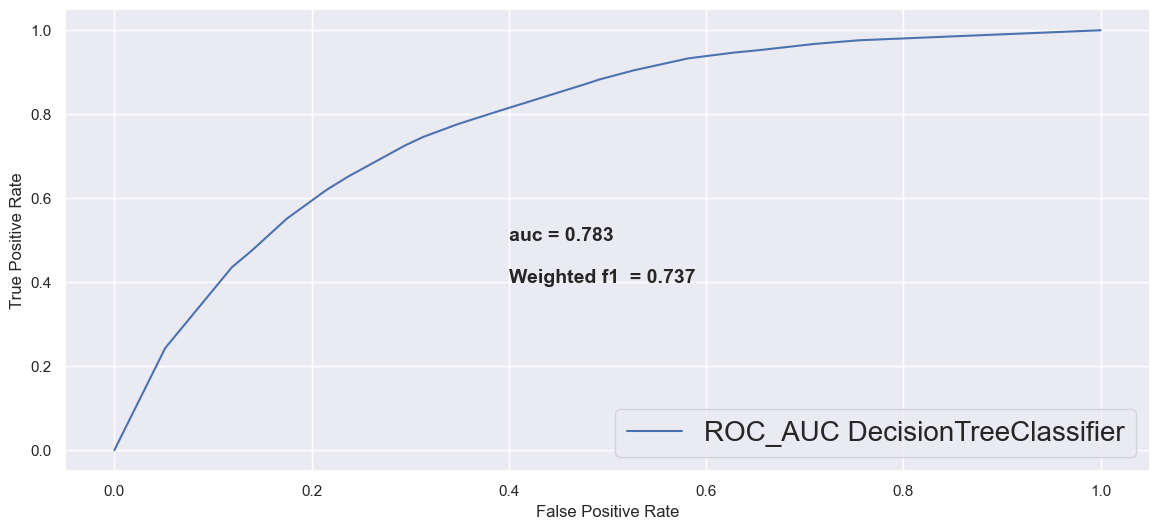

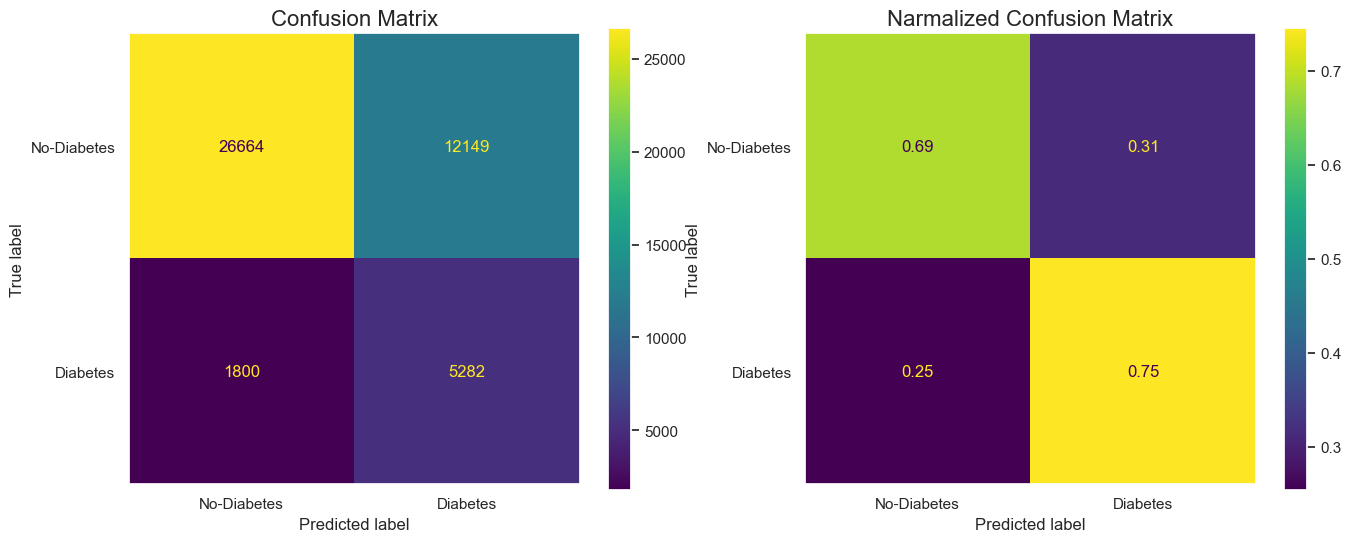

In [19]:
results.update(getMeasures(modelDT))

### DecisionTreeClassifier results:

In [20]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.744 ± 0.0132
val_roc_auc         :  0.7442 ± 0.0136
train_f1_weighted   :  0.7834 ± 0.0004
train_roc_auc       :  0.785 ± 0.0008
test_roc_auc        :  0.783 
test_f1-score       :  0.737 
-----------------------------------------


### Logistic Regression

In [52]:
%%time

model_LR = Pipeline([("processor", preprocessor),
                  ("classifier", LogisticRegression(max_iter=1000,
                                                    class_weight='balanced',
                                                    random_state=randomState))])

param_grid = {
    'classifier__C': (1e-3, 1e-2, 0.1, 1, 5, 10, 20),
}
scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_LR = GridSearchCV(model_LR,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 refit=False)
_ = model_grid_search_LR.fit(dfTrainFull, yTrainFull)

Wall time: 53 s


In [53]:
paramsLR = ["param_classifier__C"]

getResults(model_grid_search_LR, paramsLR)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__C
1,0.807635,0.000647,1,0.753902,0.000764,2,0.01
2,0.807587,0.000646,2,0.753498,0.000817,7,0.1
3,0.807579,0.000648,3,0.753481,0.000771,3,1
4,0.807578,0.000647,4,0.753466,0.000799,5,5
5,0.807576,0.000648,5,0.753466,0.000837,4,10
6,0.807576,0.000649,6,0.753434,0.000841,6,20
0,0.806012,0.000715,7,0.753918,0.000846,1,0.001


#### Selecting best parameters
Choosing C=0.01, in this case it's the beast AUC and 2nd best F1 Score

In [54]:
%%time

modelLR = Pipeline([("classifier", LogisticRegression(max_iter=1000,
                                                    C=0.01,
                                                    class_weight='balanced',
                                                    random_state=randomState))])

_ = modelLR.fit(dfTrainFull, yTrainFull)

Wall time: 5.82 s


Outer cross-validation(for testing the tunned model)

In [55]:
results = {}
results = getBestModelResults(modelLR)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7555 +/- 0.0008
val_roc_auc         :  0.7555 +/- 0.0007
train_f1_weighted   :  0.8071 +/- 0.0014
train_roc_auc       :  0.8072 +/- 0.0007


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.756
Test set auc: 0.809
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     38813
           1       0.32      0.75      0.45      7082

    accuracy                           0.72     45895
   macro avg       0.63      0.73      0.63     45895
weighted avg       0.85      0.72      0.76     45895




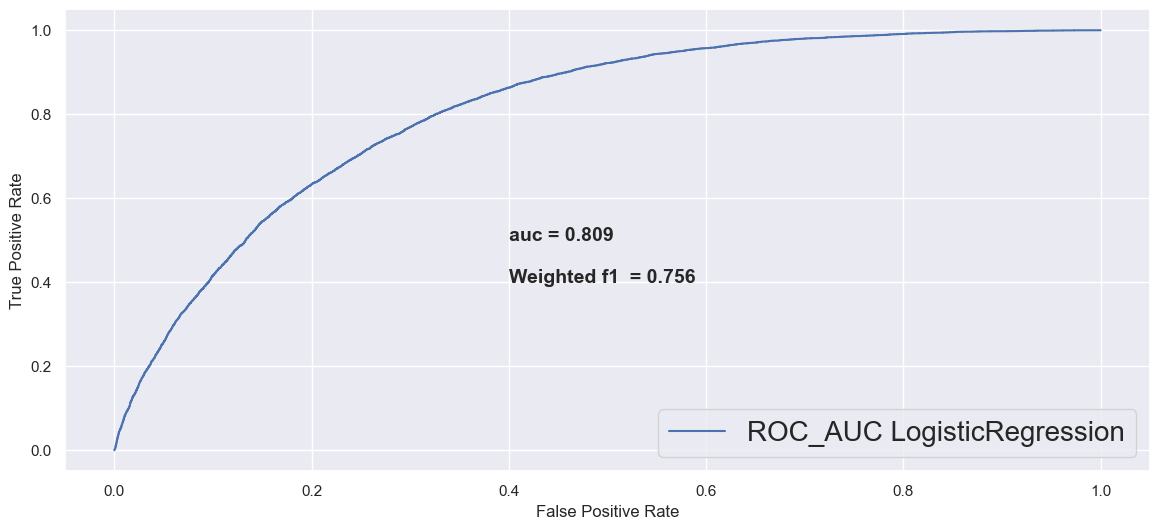

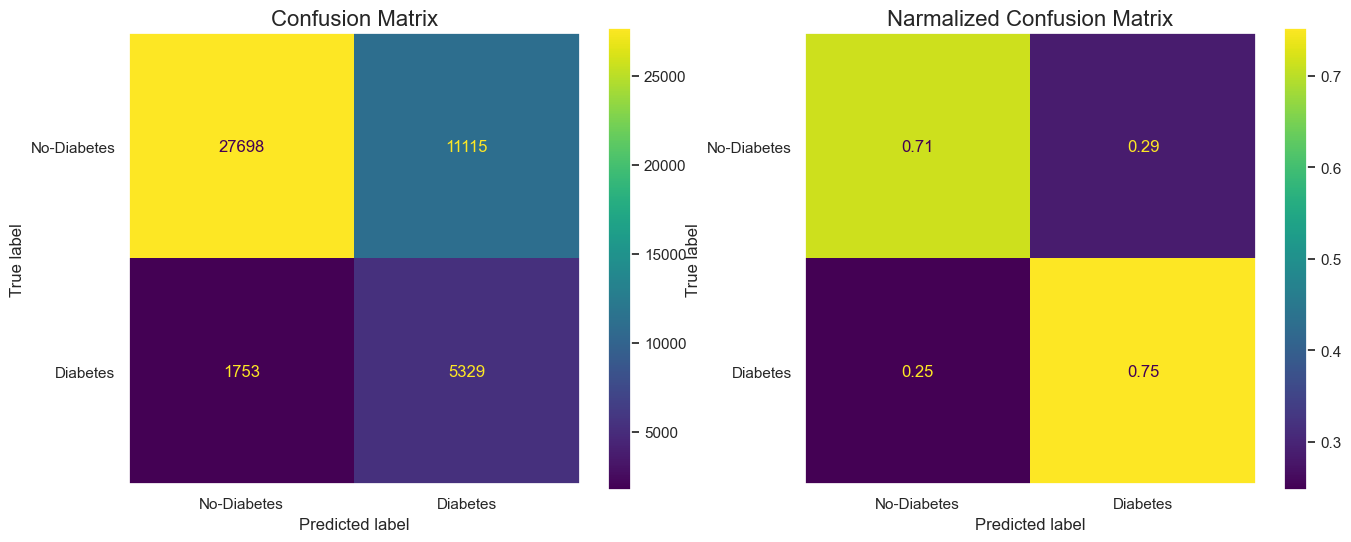

In [56]:
results.update(getMeasures(modelLR))

### Logistic Regression results:

In [57]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7555 ± 0.0008
val_roc_auc         :  0.7555 ± 0.0007
train_f1_weighted   :  0.8071 ± 0.0014
train_roc_auc       :  0.8072 ± 0.0007
test_roc_auc        :  0.809 
test_f1-score       :  0.756 
-----------------------------------------


### Random Forest

In [27]:
%%time

model_RF = Pipeline([("classifier", RandomForestClassifier(n_estimators=10,
                                                           class_weight='balanced',
                                                           random_state=randomState))])

param_grid = {
    'classifier__max_depth': (5,10,15,20,25),
    'classifier__max_leaf_nodes': (5,10,15,20,30),
    'classifier__max_features': (3,5,7,10)
}

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_RF = GridSearchCV(model_RF,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 refit=False)
_ = model_grid_search_RF.fit(dfTrainFull, yTrainFull)

Wall time: 3min 41s


In [28]:
paramsRF = ["param_classifier__max_depth",
            'param_classifier__max_leaf_nodes',
            "param_classifier__max_features"]

getResults(model_grid_search_RF, paramsRF)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features
29,0.802340,0.000626,5,0.744041,0.004599,6,10,30,5
49,0.802340,0.000626,5,0.744041,0.004599,6,15,30,5
69,0.802340,0.000626,5,0.744041,0.004599,6,20,30,5
89,0.802340,0.000626,5,0.744041,0.004599,6,25,30,5
39,0.801733,0.000766,9,0.742631,0.004675,11,10,30,10
59,0.801733,0.000766,9,0.742631,0.004675,11,15,30,10
79,0.801733,0.000766,9,0.742631,0.004675,11,20,30,10
99,0.801733,0.000766,9,0.742631,0.004675,11,25,30,10
34,0.801186,0.000974,13,0.741562,0.004339,21,10,30,7
54,0.801186,0.000974,13,0.741562,0.004339,21,15,30,7


#### Selecting best parameters
Choosing max_depth = 10, max_leaf_nodes=30 and max_features=5.

In [58]:
%%time

modelRF = Pipeline([("classifier", RandomForestClassifier(n_estimators=10,
                                                          max_depth = 10,
                                                          max_leaf_nodes=30,
                                                          max_features=5,
                                                          class_weight='balanced',
                                                          random_state=randomState))])

_ = modelRF.fit(dfTrainFull, yTrainFull)

Wall time: 756 ms


Outer cross-validation(for testing the tuned model)

In [59]:
results = {}
results = getBestModelResults(modelRF)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7464 +/- 0.0081
val_roc_auc         :  0.7471 +/- 0.0085
train_f1_weighted   :  0.8009 +/- 0.001 
train_roc_auc       :  0.8029 +/- 0.0009


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.748
Test set auc: 0.801
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.70      0.80     38813
           1       0.31      0.75      0.44      7082

    accuracy                           0.71     45895
   macro avg       0.63      0.73      0.62     45895
weighted avg       0.84      0.71      0.75     45895




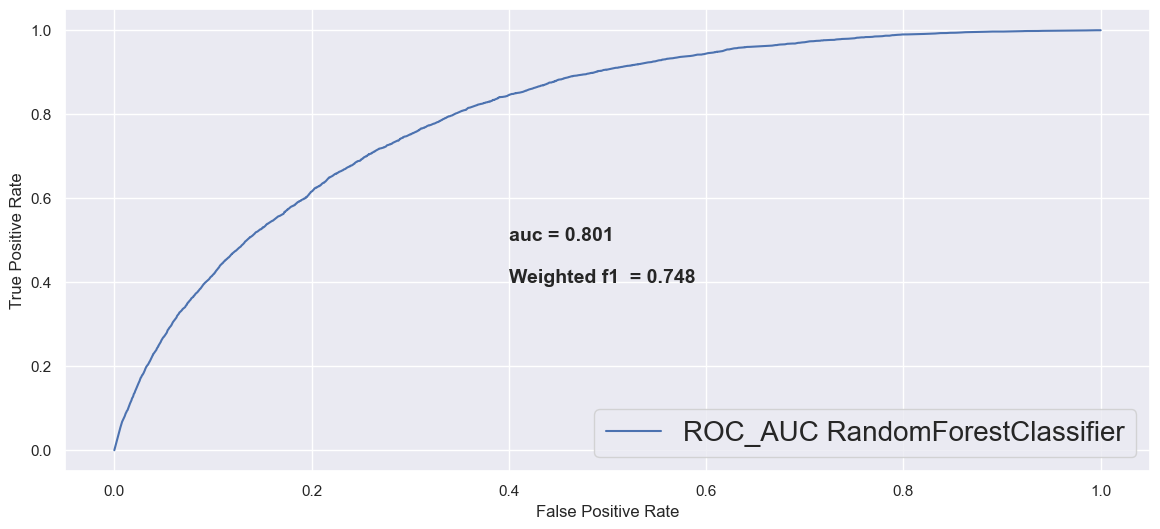

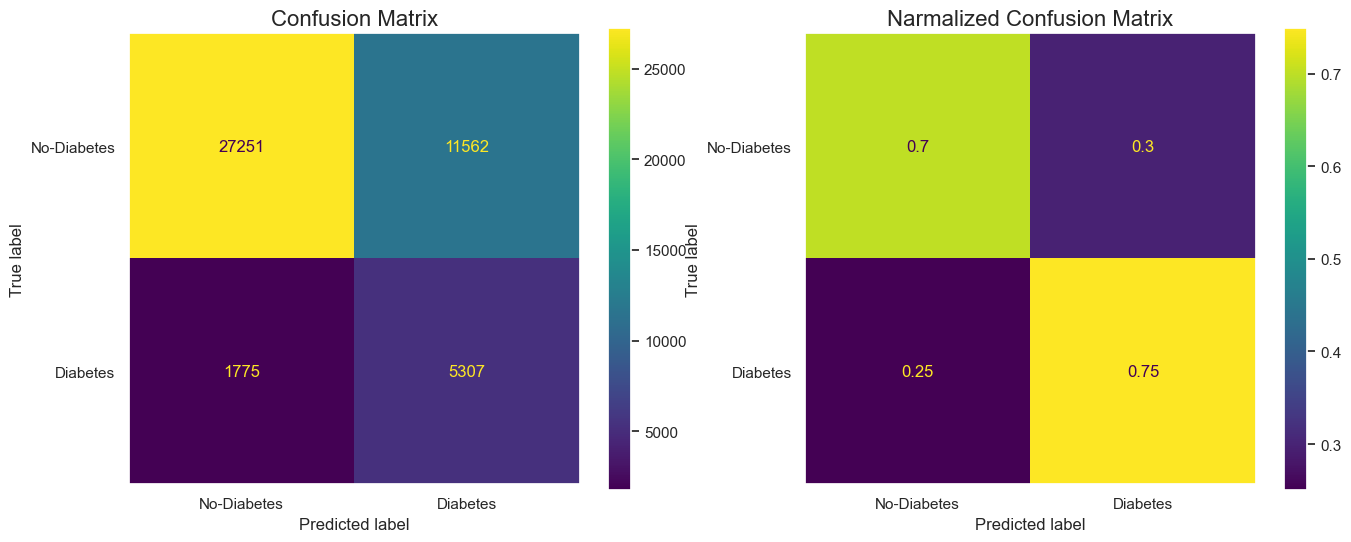

In [60]:
results.update(getMeasures(modelRF))

### Random Forest results:

In [61]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7464 ± 0.0081
val_roc_auc         :  0.7471 ± 0.0085
train_f1_weighted   :  0.8009 ± 0.001
train_roc_auc       :  0.8029 ± 0.0009
test_roc_auc        :  0.801 
test_f1-score       :  0.748 
-----------------------------------------


### XGBoost Classifier

In [33]:
imbalanceRatio = (yTrainFull==0).sum() / (yTrainFull==1).sum()
imbalanceRatio = round(imbalanceRatio, 2)
imbalanceRatio

5.55

In [34]:
%%time
# 58 min 15 s
# Inner cross-validation(for Hyperparameter tuning)
innerCV = StratifiedKFold(n_splits=3, shuffle=True, random_state=randomState)

model_XGB = Pipeline([("classifier", XGBClassifier(n_estimators=10,
                                                   random_state=randomState, 
                                                   tree_method='gpu_hist',
                                                   scale_pos_weight=imbalanceRatio)
                      )])

param_grid = {
    'classifier__max_depth' : (2, 5, 8, 10),
    'classifier__learning_rate' : (0.01, 0.1, 0.5, 0.8),
    'classifier__min_child_weight' : (1,10,20),
    'classifier__reg_lambda' : (1, 3, 5, 8),
}

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_XGB = GridSearchCV(model_XGB,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 verbose=4,                                 
                                 refit=False)

_ = model_grid_search_XGB.fit(dfTrain, yTrain)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Wall time: 1min 21s


In [35]:
paramsXGB = ["param_classifier__max_depth",
             'param_classifier__learning_rate',
             "param_classifier__min_child_weight",
             "param_classifier__reg_lambda"]

getResults(model_grid_search_XGB, paramsXGB)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__max_depth,param_classifier__learning_rate,param_classifier__min_child_weight,param_classifier__reg_lambda
110,0.819318,0.000910,1,0.748177,0.001001,118,5,0.5,1,5
109,0.819561,0.000760,2,0.749020,0.001498,107,5,0.5,1,3
113,0.819035,0.001251,3,0.747816,0.001974,122,5,0.5,10,3
114,0.819174,0.000985,4,0.749476,0.000682,98,5,0.5,10,5
117,0.818572,0.001018,5,0.748686,0.000818,103,5,0.5,20,3
111,0.819470,0.000988,6,0.749011,0.001196,101,5,0.5,1,8
119,0.818934,0.001035,7,0.748620,0.001684,100,5,0.5,20,8
115,0.819050,0.000779,8,0.748863,0.001089,99,5,0.5,10,8
118,0.818901,0.001172,9,0.748332,0.000513,111,5,0.5,20,5
108,0.819537,0.001182,10,0.749239,0.000622,106,5,0.5,1,1


#### Selecting best parameters
Choosing max_depth = 8, learning_rate = 0.5, min_child_weight = 20 and reg_lambda = 8,. It's a good compromise between a good AUC and F1 Score.

In [161]:
%%time

modelXGB = Pipeline([("classifier", XGBClassifier(n_estimators = 10,
                                                  max_depth = 8,
                                                  learning_rate = 0.5,
                                                  min_child_weight = 20,
                                                  reg_lambda = 8,
                                                  random_state=randomState, 
                                                  tree_method='gpu_hist',
                                                  scale_pos_weight=imbalanceRatio                                                  
                                                 ))
                    ])

_ = modelXGB.fit(dfTrainFull, yTrainFull)

Wall time: 478 ms


Outer cross-validation(for testing the tuned model)

In [159]:
results = {}
results = getBestModelResults(modelXGB)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.75   +/- 0.0032
val_roc_auc         :  0.7583 +/- 0.0026
train_f1_weighted   :  0.8116 +/- 0.0009
train_roc_auc       :  0.8336 +/- 0.0005


#### Curves and measures of error


---------------------------------
Test set weighted f1-score: 0.751
Test set auc: 0.813
---------------------------------

              precision    recall  f1-score   support

           0       0.94      0.70      0.81     38813
           1       0.32      0.77      0.45      7082

    accuracy                           0.71     45895
   macro avg       0.63      0.74      0.63     45895
weighted avg       0.85      0.71      0.75     45895




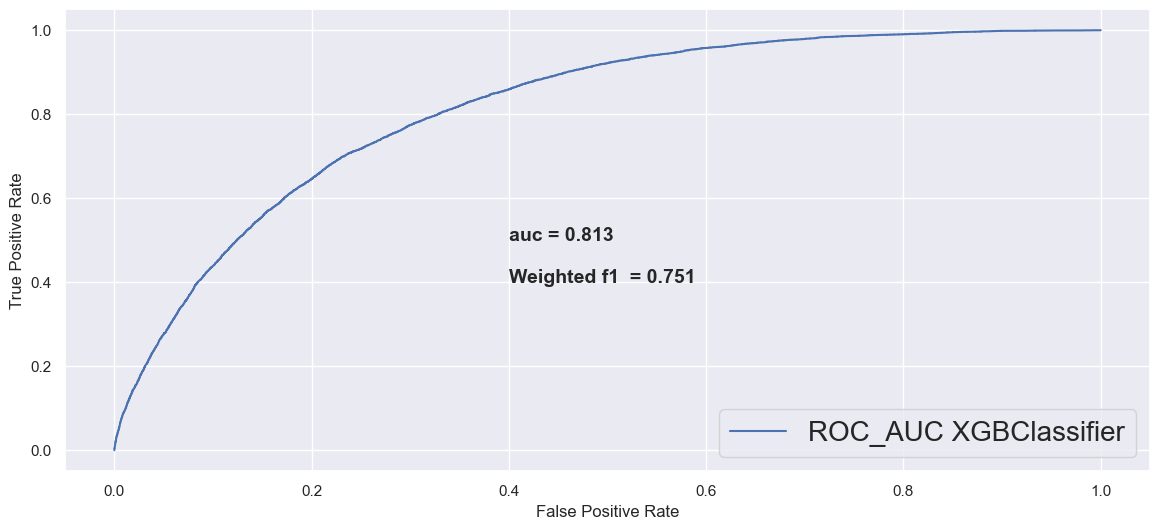

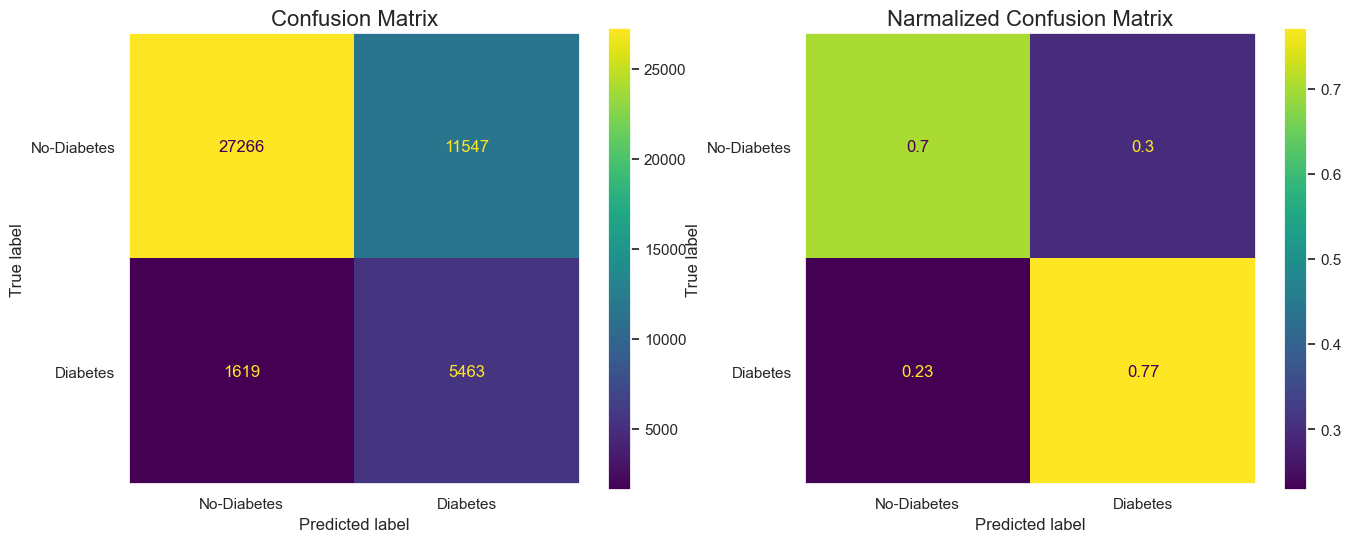

In [160]:
results.update(getMeasures(modelXGB))

### XGBoost results:

In [98]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.75 ± 0.0032
val_roc_auc         :  0.7583 ± 0.0026
train_f1_weighted   :  0.8116 ± 0.0009
train_roc_auc       :  0.8336 ± 0.0005
test_roc_auc        :  0.813 
test_f1-score       :  0.751 
-----------------------------------------


### AdaBoostClassifier

In [39]:
%%time
model_AB = Pipeline([("classifier", AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),
                                                       random_state=randomState)
                      )])

param_grid = {
    'classifier__learning_rate' : (0.1, 0.5, 1, 2),
    'classifier__base_estimator__class_weight': [None, 'balanced'],
    'classifier__base_estimator__max_depth': [1, 3, 5],
    'classifier__base_estimator__max_leaf_nodes': [1, 3, 5],
    
}

scoring = {"auc": "roc_auc", "f1_weighted": "f1_weighted"}

model_grid_search_AB = GridSearchCV(model_AB,
                                 param_grid=param_grid,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 cv=innerCV,
                                 return_train_score=True,
                                 verbose=4,                                 
                                 refit=False)

_ = model_grid_search_AB.fit(dfTrainFull, yTrainFull)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Wall time: 8min 48s


In [40]:
paramsAB = ['param_classifier__learning_rate',
            'param_classifier__base_estimator__class_weight',
            'param_classifier__base_estimator__max_depth',
            'param_classifier__base_estimator__max_leaf_nodes'
           ]

getResults(model_grid_search_AB, paramsAB)

,mean_train_auc,std_train_auc,rank_test_auc,mean_train_f1_weighted,std_train_f1_weighted,rank_test_f1_weighted,param_classifier__learning_rate,param_classifier__base_estimator__class_weight,param_classifier__base_estimator__max_depth,param_classifier__base_estimator__max_leaf_nodes
57,0.817406,0.000472,1,0.749077,0.002192,27,0.5,balanced,3,5
17,0.815079,0.000681,2,0.820722,0.000457,1,0.5,None,3,3
29,0.815079,0.000681,2,0.820722,0.000457,1,0.5,None,5,3
33,0.817700,0.000787,4,0.819499,0.001284,9,0.5,None,5,5
69,0.817323,0.000689,5,0.747940,0.002196,28,0.5,balanced,5,5
21,0.817390,0.000915,6,0.819481,0.001387,8,0.5,None,3,5
18,0.815082,0.000976,9,0.819940,0.000571,3,1,None,3,3
30,0.815082,0.000976,9,0.819940,0.000571,3,1,None,5,3
54,0.815383,0.000664,11,0.747881,0.001906,29,1,balanced,3,3
66,0.815383,0.000664,11,0.747881,0.001906,29,1,balanced,5,3


#### Selecting best parameters
Choosing max_depth = 3, max_leaf_nodes= 3  and learning_rate = 0.8 and class_weight = None.

In [99]:
%%time

modelAB = Pipeline([("classifier", AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(class_weight = 'balanced',
                                            max_depth = 3,
                                            max_leaf_nodes = 5,
                                           ), learning_rate = 0.5, random_state=randomState))
                   ])

_ = modelAB.fit(dfTrainFull, yTrainFull)

Wall time: 9.67 s


Outer cross-validation(for testing the tuned model)

In [100]:
results = {}
results = getBestModelResults(modelAB)

Scores after hyperparameters tuning:

val_f1_weighted     :  0.7476 +/- 0.0021
val_roc_auc         :  0.7491 +/- 0.0022
train_f1_weighted   :  0.8136 +/- 0.0016
train_roc_auc       :  0.8174 +/- 0.0005


#### Curves and error measures


---------------------------------
Test set weighted f1-score: 0.747
Test set auc: 0.814
---------------------------------

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     38813
           1       0.32      0.78      0.45      7082

    accuracy                           0.71     45895
   macro avg       0.63      0.74      0.63     45895
weighted avg       0.85      0.71      0.75     45895




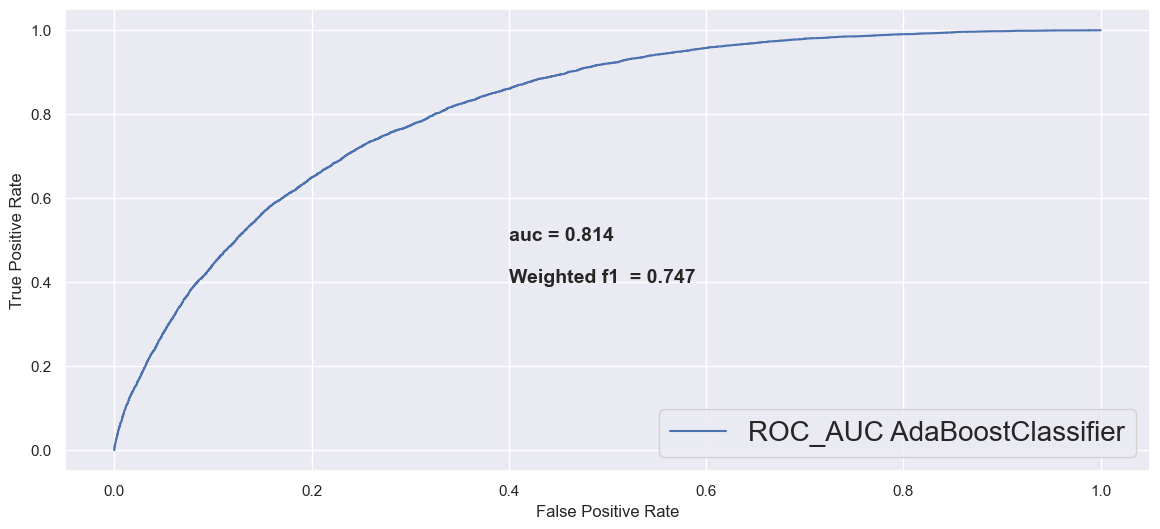

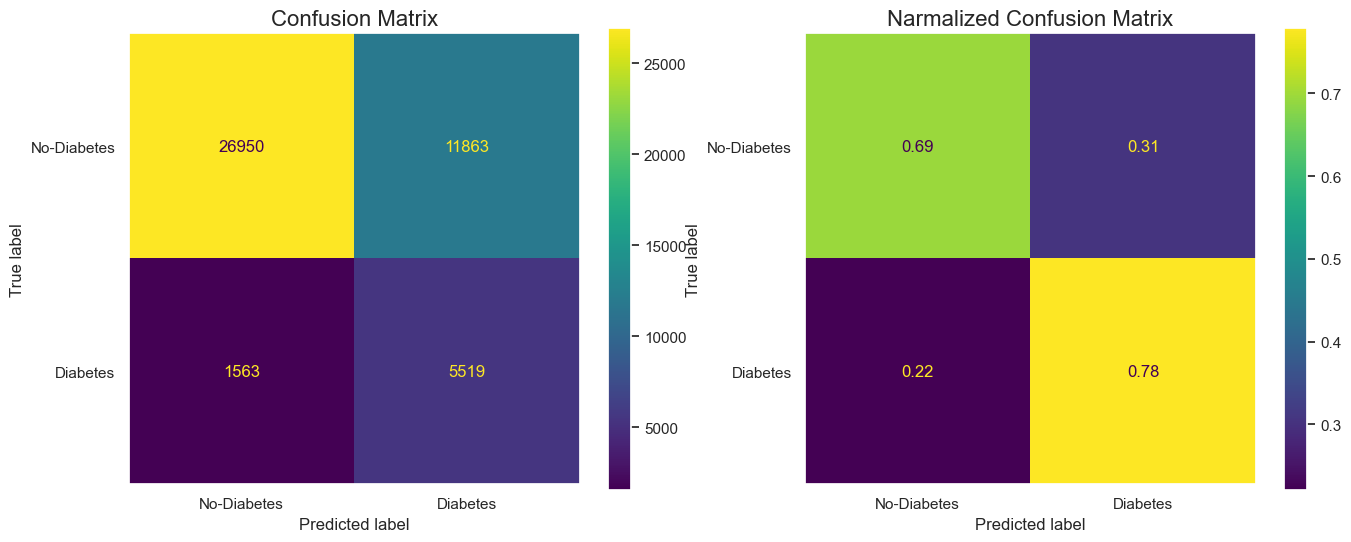

In [101]:
results.update(getMeasures(modelAB))

### AdaBoostClassifier results:

In [102]:
printResults(results)


-----------------------------------------
val_f1_weighted     :  0.7476 ± 0.0021
val_roc_auc         :  0.7491 ± 0.0022
train_f1_weighted   :  0.8136 ± 0.0016
train_roc_auc       :  0.8174 ± 0.0005
test_roc_auc        :  0.814 
test_f1-score       :  0.747 
-----------------------------------------


## Comparing models

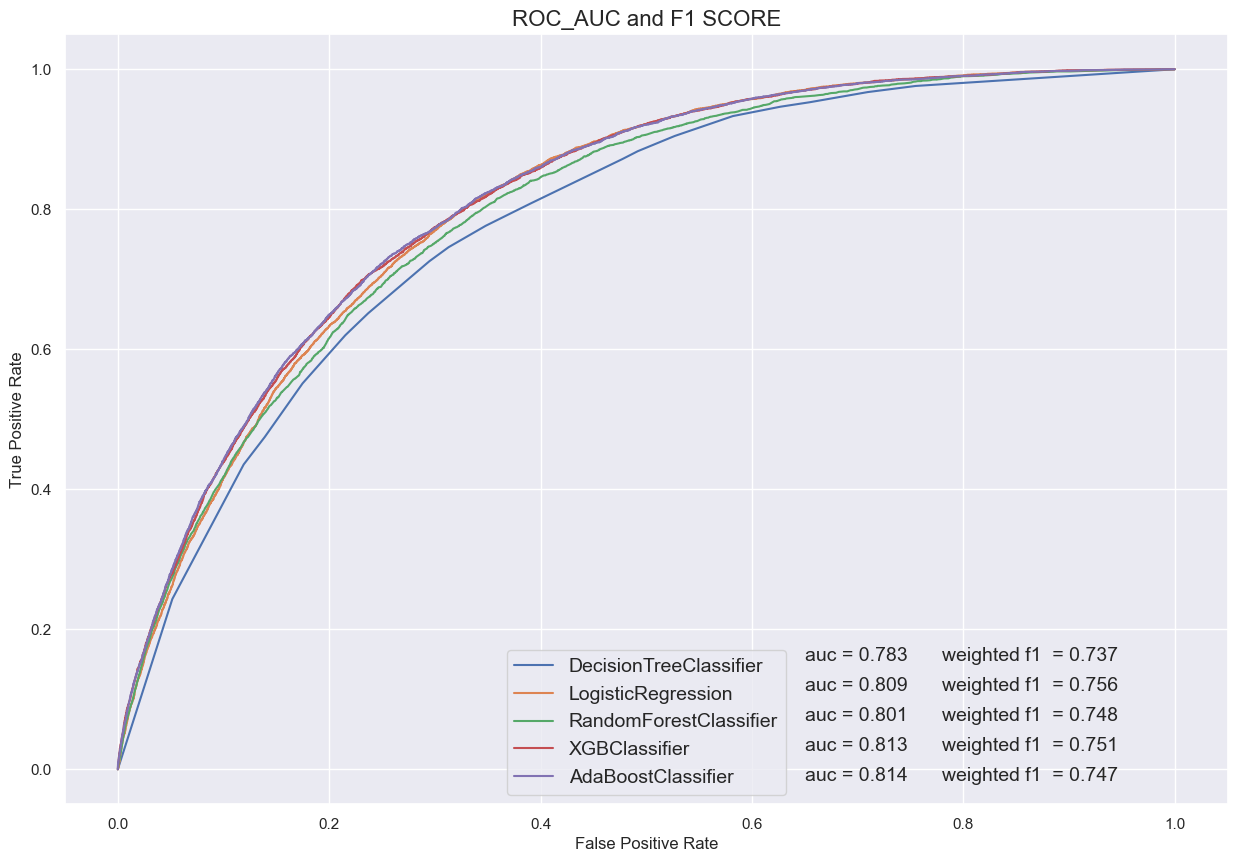

In [219]:
models = [modelDT, modelLR, modelRF, modelXGB, modelAB]

fig, ax = plt.subplots(figsize=(15, 10))
delta = 0

for model in models:

    yTestpredProb_ = model.predict_proba(dfTest)[:,1]
    yTestpred_ = model.predict(dfTest)
    modelName = type(model.named_steps.classifier).__name__
    
    auc = round(roc_auc_score(yTest, yTestpredProb_),3)
    f1Score = round(f1_score(yTest, yTestpred_, average='weighted'),3)
    
    fpr, tpr, _ = roc_curve(yTest.values, yTestpredProb_)
    roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr)
    roc_display1.plot(ax=ax, name=modelName)
    #roc_display1.ax_.(linestyle='dashed', marker='o')
    roc_display1.ax_.set_title('ROC_AUC and F1 SCORE', size= 16)
    ax.text(0.65, 0.155 - delta, f'auc = {auc}', size=14 )
    ax.text(0.78, 0.155 - delta, f'weighted f1  = {f1Score}', size=14)
    ax.legend(loc='lower center', prop={'size': 14})
    delta += 0.043  

#### In this case the best model are AdaBoostClassifier, XGBoost and Logistc regression.

## Saving Models with Pickle

In [311]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

models = [modelDT, modelLR, modelRF, modelXGB, modelAB]
for model in models:
    modelName = type(model.named_steps.classifier).__name__
    print(f'Saving pickle file for {modelName}')
    outputFile = f'models/{modelName}.bin'
    with open(outputFile, 'wb') as f:
        pickle.dump(model, f)

Saving pickle file for DecisionTreeClassifier
Saving pickle file for LogisticRegression
Saving pickle file for RandomForestClassifier
Saving pickle file for XGBClassifier
Saving pickle file for AdaBoostClassifier


## Testing model predictions

In [312]:
def predict(inputdata):
    
    #Transform inputdata to an inputdataframe
    data = pd.DataFrame(inputdata, index=[1])

    # Mappings
    sex = {'Male':0, 'Female':1}

    binary = {'Yes': 1, 'No': 0}

    education = {
        'Never attended school or only kindergarten' : 1,
        'Elementary school' : 2,
        'Some high school' : 3,
        'High school graduate' : 4,
        'Some college or technical school' : 5,
        'College graduate' : 6
    }

    income = {
        'less than $10,000'  : 1,
        '$10,000 to $15,000' : 2,
        '$15,000 to $20,000' : 3, 
        '$20,000 to $25,000' : 4,
        '$25,000 to $35,000' : 5,
        '$35,000 to $50,000' : 6,
        '$50,000 to $75,000' : 7,
        '$75,000 or  more'   : 8
    }

    genhlth = {
        'Excellent' : 1,
        'Very good' : 2,
        'Good'      : 3,
        'Fair'      : 4,
        'Poor'      : 5
    }

    def getAgeRange(age):

        if 18 <= age <= 24:
            ageRange = 1
        elif 25 <= age <= 29:
            ageRange = 2
        elif 30 <= age <= 34: 
            ageRange = 3
        elif 35 <= age <= 39: 
            ageRange = 4
        elif 40 <= age <= 44:
            ageRange = 5
        elif 45 <= age <= 49:
            ageRange = 6
        elif 50 <= age <= 54:
            ageRange = 7
        elif 55 <= age <= 59:
            ageRange = 8
        elif 60 <= age <= 64:
            ageRange = 9
        elif 65 <= age <= 69:
            ageRange = 10
        elif 70 <= age <= 74:
            ageRange = 11
        elif 75 <= age <= 79:
            ageRange = 12
        elif 80 <= age:
            ageRange = 13
        return ageRange

    # Replace values
    ageRange = getAgeRange(data.age.values)


    data.replace( binary | sex | education | income, inplace=True)
    data.age = ageRange
    data.replace( genhlth, inplace=True )
    print(data)
    # get models from folder and load models to a dictionary
    path = 'models/'
    files = os.listdir(path)
    models = {}

    for file in files:
        filename = file.split('.')[0]
        with open('models/' + file, 'rb') as f:
            models[filename] = pickle.load(f)        

    # Make predictions
    for name, model in models.items():
        yProb_ = (model.predict_proba(data)[:,1]*100).round(0)
        yPred_ = model.predict(data)
        print(f'{name:<22} : {int(yProb_[0])} %')# = {yPred_}')


### Two testing examples

#### Likely a negative testing example

In [293]:
inputData = {
    'highbp': 'No',
    'highchol': 'No',
    'cholcheck': 'Yes',
    'bmi': 27,
    'smoker': 'Yes',
    'stroke': 'No',
    'heartdiseaseorattack': 'No',
    'physactivity': 'Yes',
    'hvyalcoholconsump': 'No',
    'genhlth':  'Good',
    'menthlth': 0,
    'physhlth': 0,
    'diffwalk': 'No',
    'sex': 'Male',
    'age': 62,
    'education': 'College graduate',
    'income': '$75,000 or  more'
}

predict(inputData)

AdaBoostClassifier     : 49 %
DecisionTreeClassifier : 32 %
LogisticRegression     : 25 %
RandomForestClassifier : 39 %
XGBClassifier          : 35 %


#### Likely a positve testing example

In [308]:
inputData = {
    'highbp': 'Yes',
    'highchol': 'Yes',
    'cholcheck': 'Yes',
    'bmi': 22,
    'smoker': 'No',
    'stroke': 'No',
    'heartdiseaseorattack': 'Yes',
    'physactivity': 'No',
    'hvyalcoholconsump': 'No',
    'genhlth': 'Fair',
    'menthlth': 0,
    'physhlth': 10,
    'diffwalk': 'No',
    'sex': 'Male',
    'age': 52,
    'education': 'High school graduate',
    'income': 'less than $10,000'
}

predict(inputData)

   highbp  highchol  cholcheck  bmi  smoker  stroke  heartdiseaseorattack  \
1     1        1         1      22      0       0              1            

   physactivity  hvyalcoholconsump  genhlth  menthlth  physhlth  diffwalk  \
1        0               0             4         0        10         0      

   sex  age  education  income  
1   0    7       4         1    
AdaBoostClassifier     : 51 %
DecisionTreeClassifier : 68 %
LogisticRegression     : 66 %
RandomForestClassifier : 73 %
XGBClassifier          : 80 %


In [303]:
df.iloc[645].to_dict()

{'diabetes': 1,
 'highbp': 1,
 'highchol': 1,
 'cholcheck': 1,
 'bmi': 26,
 'smoker': 0,
 'stroke': 0,
 'heartdiseaseorattack': 0,
 'physactivity': 1,
 'hvyalcoholconsump': 0,
 'genhlth': 4,
 'menthlth': 0,
 'physhlth': 0,
 'diffwalk': 0,
 'sex': 0,
 'age': 9,
 'education': 5,
 'income': 3}

In [313]:
inputData = { 'highbp': 'Yes',
 'highchol': 'Yes',
 'cholcheck': 'Yes',
 'bmi': 26,
 'smoker': 'No',
 'stroke': 'No',
 'heartdiseaseorattack': 'No',
 'physactivity': 'Yes',
 'hvyalcoholconsump': 'No',
 'genhlth': 4,
 'menthlth': 0,
 'physhlth': 0,
 'diffwalk': 'No',
 'sex': 0,
 'age': 62,
 'education': 'Some college or technical school',
 'income': '$15,000 to $20,000'}


predict(inputData)

   highbp  highchol  cholcheck  bmi  smoker  stroke  heartdiseaseorattack  \
1     1        1         1      26      0       0              0            

   physactivity  hvyalcoholconsump  genhlth  menthlth  physhlth  diffwalk  \
1        1               0             4         0         0         0      

   sex  age  education  income  
1   0    9       5         3    
AdaBoostClassifier     : 51 %
DecisionTreeClassifier : 68 %
LogisticRegression     : 72 %
RandomForestClassifier : 69 %
XGBClassifier          : 77 %
